In [1]:
import numpy as np
from scipy.integrate import odeint

from util.util import _fix_seed, add_noise, normalize, inverse_normalize

from util.plot import plot_time_series, plot_piston_spring_trajectories
from data.piston_spring import piston_spring_args, piston_spring, prepare_data
from models.piston_spring import PistonSpring, PistonSpringNN

In [2]:
# To get nice plots
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['text.usetex'] = True

# For reproducibility
_fix_seed(seed=0)

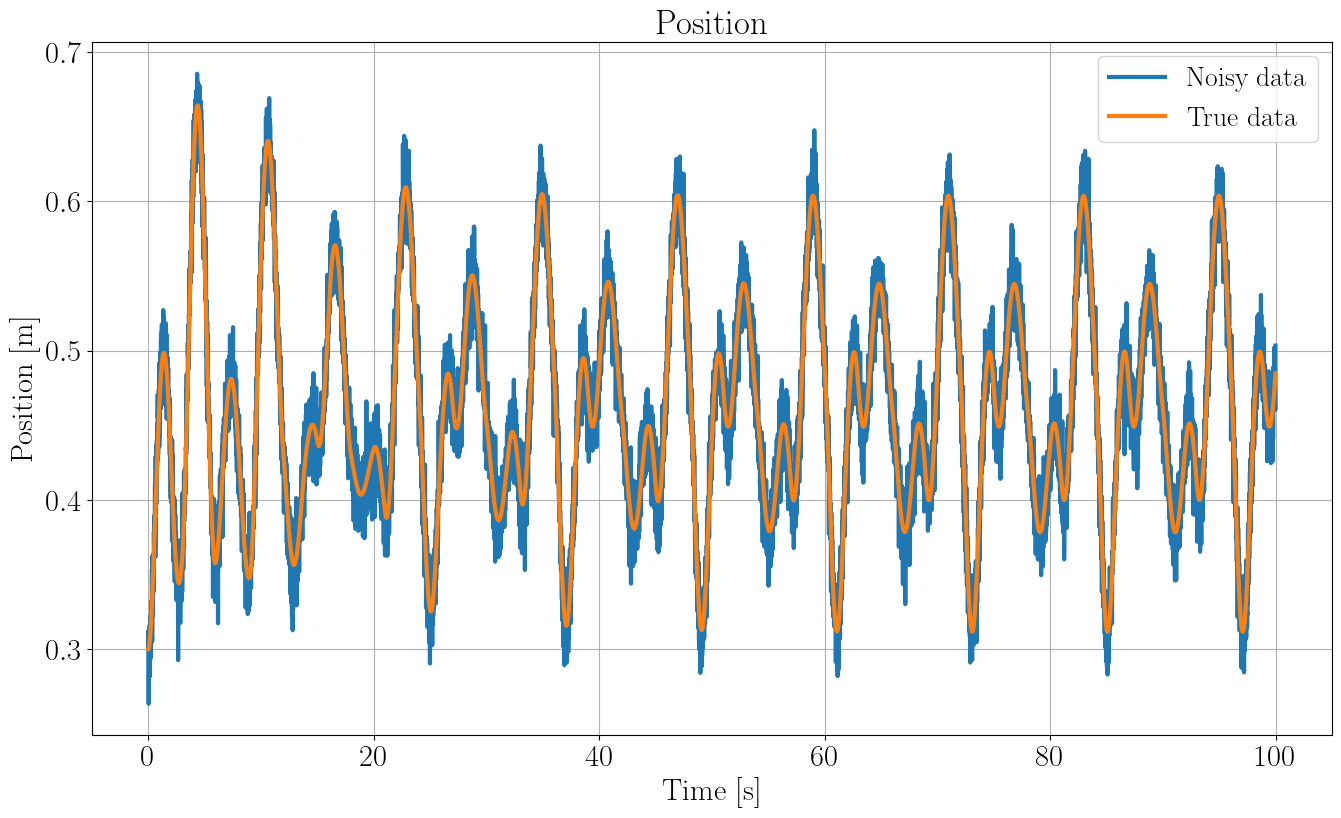

In [3]:
# Prepare the system
m_system, A_piston, mu, n_mol, K_spring, mc_air, x0, S0, V0, T0, h, N = piston_spring_args()

# Simulate it
t = np.linspace(0, N*h, N)
args = (m_system, A_piston, mu, n_mol, K_spring, mc_air, S0, V0, T0)
sol = odeint(piston_spring, x0, t, args=args)

# Add Gaussian noise
sol_noisy = add_noise(data=sol, std_scale=0.2)

# Plot the position data
plot_time_series(t=t, data=[sol_noisy[:, 2], sol[:, 2]], labels=['Noisy data', 'True data'], title='Position', ylabel='Position [m]')

In [4]:
m_system, A_piston, mu, n_mol, K_spring, mc_air

(5, 0.03333333333333333, 1, 0.008314410000000001, 10, 500)


Trying to load a trained model...
Found!
The model has been fitted for 2204 epochs already, with loss  0.00016.

Trying to load a trained model...
Found!
The model has been fitted for 12126 epochs already, with loss  0.00005.


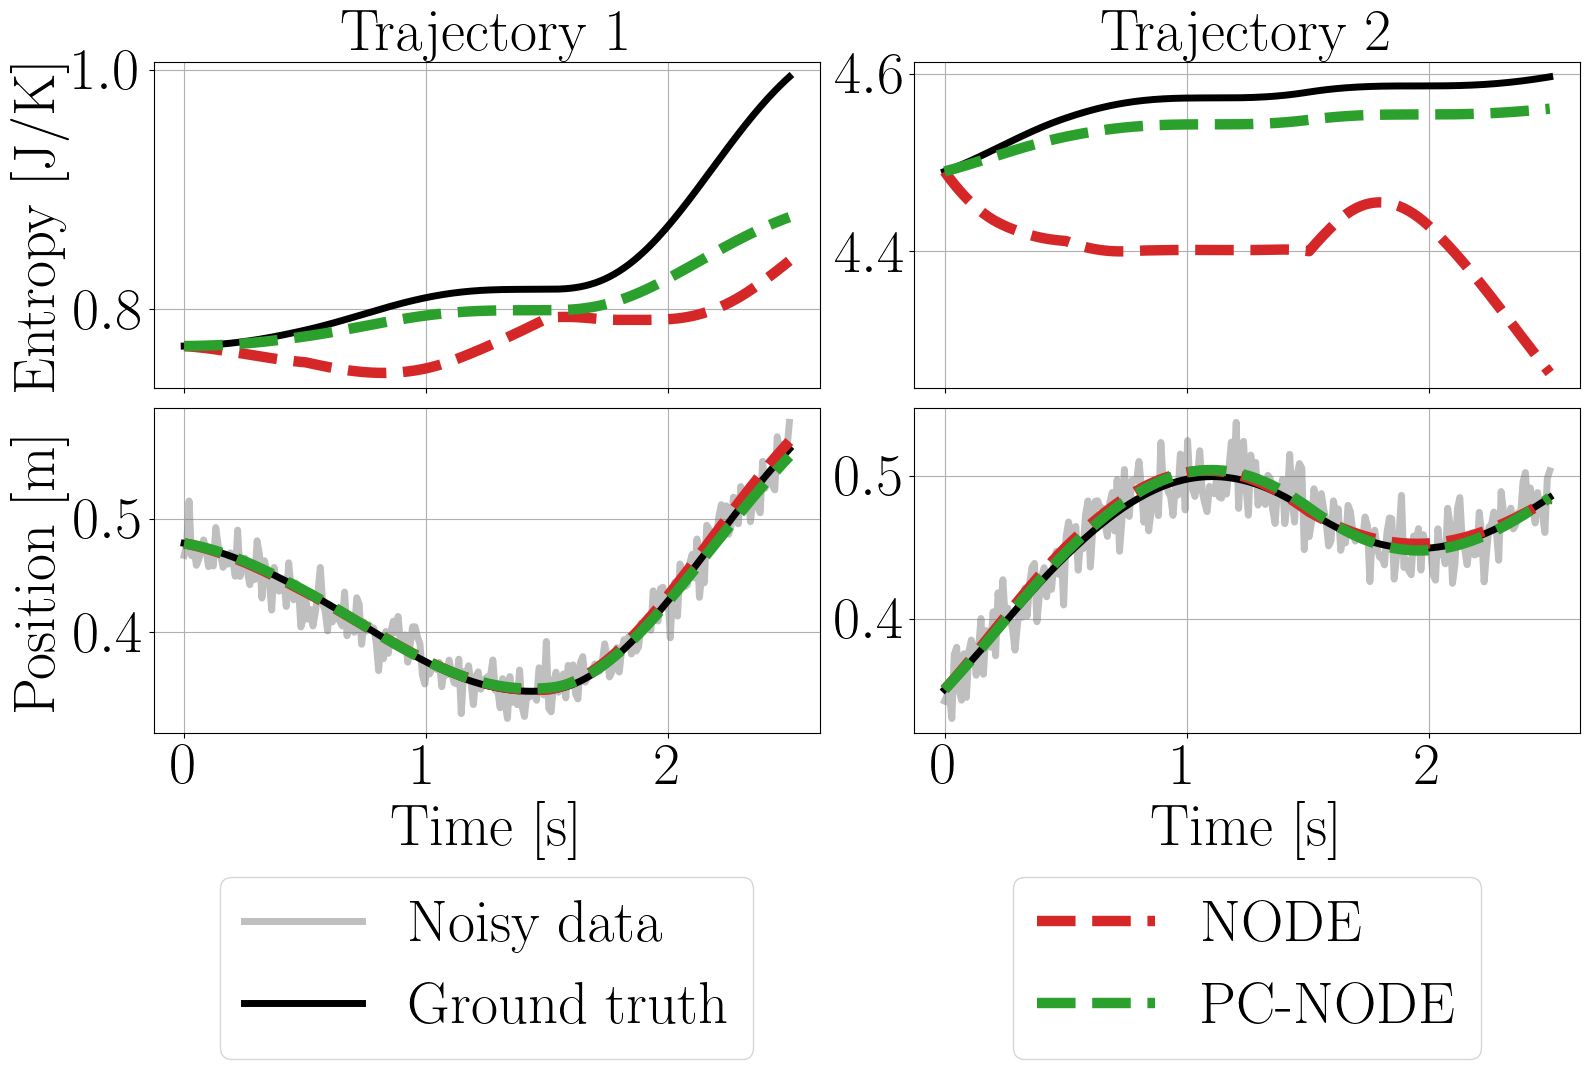

In [5]:
# Set to False to train from scratch
try_to_load = True
# Set custom names to train new pinodes - below are the pretrained ones
name = 'default_NN'
name_H_J = 'default_H_J_norm'

# Prepare the data, i.e. cut the data set in sequences of a certain length
U, X, U_val, X_val, U_arx, X_arx, U_val_arx, X_val_arx = prepare_data(t, sol, sol_noisy, cut=250)

norm_U, norm_X, norm_U_val, norm_X_val, (min_, max_) = normalize(U, X, U_val, X_val)

# Define and fit the PiNODE with parametrized H and J - this can take a while
classical_nn = PistonSpringNN(sizes=[32,32], nx=4, nu=1, h=h, parametrize_H_J=True, lr=.001, try_to_load=try_to_load, name=name)
pcnode_H_J = PistonSpring(nx=4, nu=1, h=h, parametrize_H_J=True, lr=0.003, try_to_load=try_to_load, name=name_H_J)

if not try_to_load:
    classical_nn.fit(norm_U, norm_X, norm_U_val, norm_X_val, n_epochs=20000, print_each=250)
    pcnode_H_J.fit(norm_U, norm_X, norm_U_val, norm_X_val, n_epochs=20000, print_each=250)
    
plot_piston_spring_trajectories(pcnode_H_J, classical_nn, norm_X, norm_X_val, norm_U_val, init_val=None, min_=min_, max_=max_, scale=2.5)